# Poisson log-normal datasets - test with NB means and average expressions

## Imports

In [2]:
import glob
import pandas as pd
import numpy as np
import os
from IPython.display import HTML
import scipy
import torch
import pickle
import re
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from inspect import signature

In [3]:
from scvi.models import AutoZIVAE
from scvi.inference import UnsupervisedTrainer
from datasets.poissonlognormal import ZIFAPoissonLogNormalDatasetMixed
import torch
import pickle
import argparse
import re
import numpy as np
import time
from scvi.models.log_likelihood import compute_marginal_log_likelihood_scvi, compute_marginal_log_likelihood_autozi
import os
from autozi_simulate_tools import retrieve_rates_dropouts
from classification_metrics import *

[2019-10-11 19:29:52,720] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/home/oscar/miniconda3/lib/python3.7/site-packages/scikit_learn-0.19.2-py3.7-linux-x86_64.egg/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
plt.switch_backend("TkAgg")
%matplotlib inline

## Train AutoZI on datasets

For each dataset under scrutiny, we retrieve the posterior parameters $\alpha^g, \beta^g$ of $q(\delta_g)$  as well as average expressions and average estimated NB means for each gene $g$

In [5]:
results_autozi_outputs = []
for loc_reduce in [9,8,7,6,5,4]:
    for zi_share in [0.5]:
        data = ZIFAPoissonLogNormalDatasetMixed(n_cells=12000, loc_reduce=loc_reduce, dropout_coef=0.1, \
                                                dropout_lambda=0., zero_inflation_share=zi_share, separate_reduce=True)

        np.random.seed(int(time.time()))
        torch.manual_seed(int(time.time()))
        model = AutoZIVAE(n_input=data.nb_genes, alpha_prior=0.5, beta_prior=0.5,minimal_dropout=0.01)
        trainer = UnsupervisedTrainer(model, data)
        trainer.train(n_epochs=200, lr=1e-2)
        outputs = trainer.model.get_alphas_betas(as_numpy=True)
        
        outputs['dataset_name'] = 'plnreduced{zi_share}zi{loc_reduce}fold'.format(zi_share=zi_share, loc_reduce=loc_reduce)
        full = trainer.create_posterior(trainer.model, data, indices=np.arange(len(data)))
        px_dropout_probs, px_rates, px_rates_all = retrieve_rates_dropouts(model,full)
        outputs['dropout_probs_full'] = px_dropout_probs
        outputs['px_rates_gene'] = px_rates
        outputs['px_rates_cell-gene'] = px_rates_all
        outputs['means_emp'] = data.X.mean(axis=0)
        outputs['is_nb_gt'] = data.no_zi_genes
        results_autozi_outputs.append(outputs)

[2019-10-11 19:30:00,295] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-11 19:30:00,296] INFO - scvi.dataset.dataset | Remapping labels to [0,N]


training: 100%|██████████| 200/200 [02:48<00:00,  1.21it/s]


[2019-10-11 19:32:52,268] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-11 19:32:52,270] INFO - scvi.dataset.dataset | Remapping labels to [0,N]


training: 100%|██████████| 200/200 [02:54<00:00,  1.02it/s]


[2019-10-11 19:35:49,287] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-11 19:35:49,292] INFO - scvi.dataset.dataset | Remapping labels to [0,N]


training: 100%|██████████| 200/200 [03:15<00:00,  1.07it/s]


[2019-10-11 19:39:06,117] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-11 19:39:06,118] INFO - scvi.dataset.dataset | Remapping labels to [0,N]


training: 100%|██████████| 200/200 [02:57<00:00,  1.24it/s]


[2019-10-11 19:42:05,062] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-11 19:42:05,064] INFO - scvi.dataset.dataset | Remapping labels to [0,N]


training: 100%|██████████| 200/200 [03:41<00:00,  1.36s/it]


[2019-10-11 19:45:47,903] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-11 19:45:47,905] INFO - scvi.dataset.dataset | Remapping labels to [0,N]


training: 100%|██████████| 200/200 [04:32<00:00,  1.23s/it]


## Compute metrics from AutoZI's outputs

For each dataset under scrutiny, from these $\alpha^g, \beta^g$, we estimate the ZI probabilities $q(\delta_g < 0.5)$ using tools from `classification_metrics.py`.

In [10]:
results_autozi_data_list = []

for outputs in results_autozi_outputs:
    is_zinb_gt = ~outputs['is_nb_gt']
    dataset_name = outputs['dataset_name']

    model_score_evals = [
        AutoZIBernoulliThresholdEval('bernoullithreshold50', outputs, [], threshold=0.50),
    ]

    results_autozi_data = {}
    for model_score_eval in model_score_evals:
        # Directly add ZI probabilities
        results_autozi_data[model_score_eval.name] = model_score_eval.scores
    results_autozi_data['is_zinb_gt'] = is_zinb_gt

    for key in ['means_emp','px_rates_gene','dataset_name']:
        results_autozi_data[key] = outputs.get(key,None)
        
    results_autozi_data_list.append(results_autozi_data)

results_autozi = pd.DataFrame(results_autozi_data_list)

In [11]:
results_autozi = results_autozi.sort_values(by=['dataset_name']).set_index(['dataset_name'])

## Retrieve all scores, NB means and average expressions

In [12]:
scores_autozi_all = np.concatenate(list(results_autozi.bernoullithreshold50.values.reshape(-1))).reshape(-1)
nbmeans_autozi_all = np.concatenate(list(results_autozi.px_rates_gene.values.reshape(-1))).reshape(-1)
avgexps_autozi_all = np.concatenate(list(results_autozi.means_emp.values.reshape(-1))).reshape(-1)
is_zinb_gt_all = np.concatenate(list(results_autozi.is_zinb_gt.values.reshape(-1))).reshape(-1)
is_zinb_pred_all = scores_autozi_all > 0.5

## Show right and wrong predictions of AutoZI wrt NB means and average expressions

NB
Percentage of right predictions with average expressions > 1
0.9115646258503401
Percentage of right predictions with average expressions < 1
0.0
Fraction of average expressions < 1 for wrong predictions
0.9216867469879518
Percentage of right predictions in general
0.44666666666666666


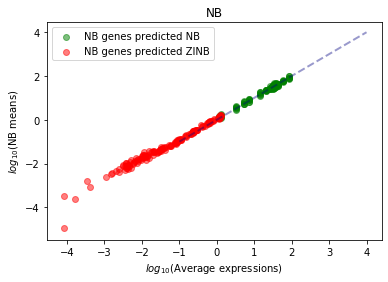

ZINB
Percentage of right predictions with average expressions > 1
0.99375
Percentage of right predictions with average expressions < 1
1.0
Fraction of average expressions < 1 for wrong predictions
0.0
Percentage of right predictions in general
0.9966666666666667


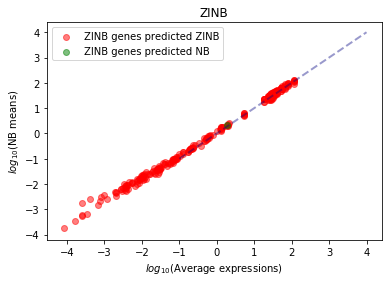

In [13]:
logs = True

reconst_loss = {False: 'NB', True: 'ZINB'}


for is_zinb_gt in [False,True]:
    
    print(reconst_loss[is_zinb_gt])
    print('Percentage of right predictions with average expressions > 1')
    print((is_zinb_pred_all == is_zinb_gt_all)[(avgexps_autozi_all > 1.) & (is_zinb_gt_all == is_zinb_gt)].mean())
    print('Percentage of right predictions with average expressions < 1')
    print((is_zinb_pred_all == is_zinb_gt_all)[(avgexps_autozi_all < 1) & (is_zinb_gt_all == is_zinb_gt)].mean())
    print('Fraction of average expressions < 1 for wrong predictions')
    print((avgexps_autozi_all < 1.)[(is_zinb_pred_all != is_zinb_gt_all) & (is_zinb_gt_all == is_zinb_gt)].mean())
    print('Percentage of right predictions in general')
    print((is_zinb_pred_all == is_zinb_gt_all)[(is_zinb_gt_all == is_zinb_gt)].mean())
    
    
    fig = plt.figure()
    axes = plt.gca()
    
    if logs:
        nbmeans_autozi_all_copy = np.log10(nbmeans_autozi_all)
        avgexps_autozi_all_copy = np.log10(avgexps_autozi_all)
    else:
        nbmeans_autozi_all_copy = nbmeans_autozi_all
        avgexps_autozi_all_copy = avgexps_autozi_all
        
    plt.plot([-1, 4], [-1, 4], color='navy', lw=2, linestyle='--', alpha=0.4)
    for is_zinb_pred in [is_zinb_gt,not(is_zinb_gt)]:
        color = 'red' if is_zinb_pred else 'green'
        label = '{} genes predicted {}'.format(reconst_loss[is_zinb_gt],reconst_loss[is_zinb_pred])
        plt.scatter(x=avgexps_autozi_all_copy[(is_zinb_gt_all == is_zinb_gt) & (is_zinb_pred_all == is_zinb_pred)],\
                    y=nbmeans_autozi_all_copy[(is_zinb_gt_all == is_zinb_gt) & (is_zinb_pred_all == is_zinb_pred)],\
                    label=label, color=color, alpha=0.5)
        
    
    plt.xlabel('$log_{10}$(Average expressions)')
    plt.ylabel('$log_{10}$(NB means)')
    plt.title(reconst_loss[is_zinb_gt])
    plt.legend(loc='upper left')
    
    plt.show()